# MSc Thesis - Hugo Stam

### Example 02 - Offshore Port System - Barges

<img src="Figures/system_layout_alternative_2B.png" style="width:1000px">

##### Investment Strategy Simulation - Adaptive terminal planning in the light of an uncertain future

* [**0. Prepare inputs:**](#0.-Prepare-inputs)<br>
   * [**0.1 Generate demand forecast scenario:**](#0.1-Generate-demand-forecast-scenario)<br>
   * [**0.2 Generate vessels:**](#0.2-Generate-vessels)<br>
* [**1. Instatiate system components:**](#1.-Instatiate-system-components)<br>
* [**2. Start simulation:**](#2.-Strart-simulation)<br>
* [**3. Report all elements:**](#3.-Report-all-elements)<br>

In [1]:
# packages for data handling
import numpy as np
import pandas as pd
import statistics as st

# packages for figures
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
# %matplotlib inline
%matplotlib notebook

import seaborn as sns
sns.set(style="ticks")
# sns.set_style("whitegrid")
# sns.set(style="darkgrid", palette = "pastel")
# sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# OpenTISim package
from opentisim import container_objects
from opentisim import container_defaults
from opentisim import container_system_offshore_barge

# OpenCLSim package
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# Additional import to save the initialisation of the simulation
import openclsim.savesim as savesim

# Pretty-print a Python object to a stream
from pprint import pprint

# Jupyter Widgets
import ipywidgets as widgets
from IPython.display import HTML

# Scroll to specific cell
from jupyter_helpers.utilities import scroll_to_current_cell

# no warnings
import warnings
warnings.filterwarnings('ignore')

# 0. Prepare inputs

In [2]:
# iPython Widgests
life_cycle = widgets.IntSlider(value=10, min=10, max=30, step=5, description='Life cycle:')
annual_demand = widgets.IntSlider(value=1000000, min=500000, max=1500000, step=50000, description='Demand:')
offshore_onshore_distance = widgets.IntSlider(value=40, min=20, max=60, step=20, description='Distance:')

container_ship = widgets.Dropdown(options=[('Post Panamax I (6,000 TEU)', 6000),
                                           ('New-Panamax (12,500 TEU)', 12500),
                                           ('ULCS (21,000 TEU)', 21000)], 
                                  value=12500, description='OGV:')

barge = widgets.Dropdown(options=[('Small (200 TEU)', 200), 
                                  ('Medium (250 TEU)', 250),
                                  ('Large (300 TEU)', 300)], 
                         value=250, description='Barge:')

foreshore_slope = widgets.Dropdown(options=[('Gently (3 km/m)', 3.0), 
                                            ('Average (2 km/m)', 2.0),
                                            ('Steep (1 km/m)', 1.0)], 
                                   value=2.0, description='Slope:')

print('\033[1m*** Input Values \033[0m')
display(annual_demand, offshore_onshore_distance, container_ship, barge, 
        foreshore_slope, life_cycle)

*** Input Values 


IntSlider(value=1000000, description='Demand:', max=1500000, min=500000, step=50000)

IntSlider(value=40, description='Distance:', max=60, min=20, step=20)

Dropdown(description='OGV:', index=1, options=(('Post Panamax I (6,000 TEU)', 6000), ('New-Panamax (12,500 TEU…

Dropdown(description='Barge:', index=1, options=(('Small (200 TEU)', 200), ('Medium (250 TEU)', 250), ('Large …

Dropdown(description='Slope:', index=1, options=(('Gently (3 km/m)', 3.0), ('Average (2 km/m)', 2.0), ('Steep …

IntSlider(value=10, description='Life cycle:', max=30, min=10, step=5)

In [3]:
offshore_distance = offshore_onshore_distance.value
demand = annual_demand.value
design_container_ship = container_ship.value
design_barge = barge.value
slope = foreshore_slope.value
lifecycle = life_cycle.value

print('The offshore distance:', offshore_distance, 'km')
print('The annual demand:', demand, 'TEU')
print('The design container ship capacity:', design_container_ship, 'TEU')
print('The design barge capacity:', design_barge, 'TEU')
print('The slope of the foreshore:', slope, 'in km reach per meter water depth')
print('The design life cycle:', lifecycle, 'years')

avg_parcel = design_container_ship / 8

startyear = 2020

The offshore distance: 40 km
The annual demand: 1000000 TEU
The design container ship capacity: 12500 TEU
The design barge capacity: 250 TEU
The slope of the foreshore: 2.0 in km reach per meter water depth
The design life cycle: 10 years


## 0.1 Generate demand forecast scenario

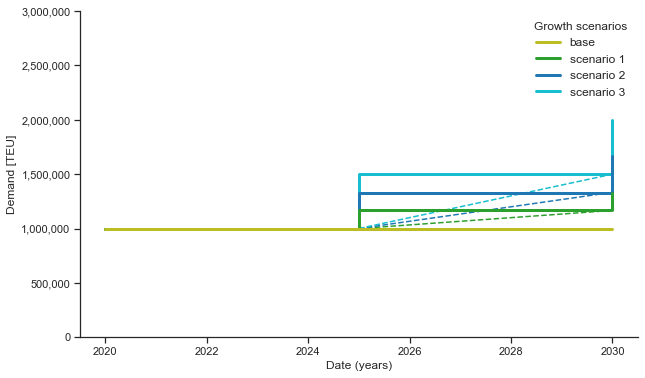

In [4]:
container = demand  # TEU
years = list(range(startyear, startyear+lifecycle+1))

trend_1 = []
trend_2 = []
trend_3 = []

for i in range(lifecycle-4):
    trend_1.append(container +   500_000/15 * i)
    trend_2.append(container + 1_000_000/15 * i)
    trend_3.append(container + 1_500_000/15 * i)

demand_0 = []
demand_1 = []
demand_2 = []
demand_3 = []

for year in years:
    if year < 2025:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.00))
        demand_2.append(int(container * 1.00))
        demand_3.append(int(container * 1.00))
        
    elif year < 2030:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.17))
        demand_2.append(int(container * 1.33))
        demand_3.append(int(container * 1.50))
    elif year < 2035:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.33))
        demand_2.append(int(container * 1.67))
        demand_3.append(int(container * 2.00))
    else:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.50))
        demand_2.append(int(container * 2.00))
        demand_3.append(int(container * 2.50))

# figure 
plt.figure(figsize=(10,6))

plt.plot(years[5:lifecycle+1], trend_1, color='tab:green', linestyle='--', zorder=0)
plt.plot(years[5:lifecycle+1], trend_2, color='tab:blue' , linestyle='--', zorder=0)
plt.plot(years[5:lifecycle+1], trend_3, color='tab:cyan' , linestyle='--', zorder=0)

plt.step(years, demand_0, color='tab:olive', linewidth=3, label='base', where='post', zorder=4)
plt.step(years, demand_1, color='tab:green', linewidth=3, label='scenario 1', where='post', zorder=3)
plt.step(years, demand_2, color='tab:blue' , linewidth=3, label='scenario 2', where='post', zorder=2)
plt.step(years, demand_3, color='tab:cyan' , linewidth=3, label='scenario 3', where='post', zorder=1)
    
plt.xlabel("Date (years)", fontsize='large')

if lifecycle == 20:
    plt.xticks([2020, 2025, 2030, 2035, 2040])

plt.yticks([0, 0.5e6, 1e6, 1.5e6, 2e6, 2.5e6, 3e6],
           [0, '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000'])
plt.ylabel('Demand [TEU]', fontsize='large')

plt.legend(loc='best', title='Growth scenarios', title_fontsize='large', fontsize='large', frameon=False)

# figure aesthetics
plt.grid(False, which='major')
sns.despine(top=True)

# save fig
if lifecycle == 20:
    plt.savefig("SaveFigures/growth_scenarios.png")

In [5]:
if lifecycle == 20:
    years = years[0:20]
    demand_0 = demand_0[0:20]
    demand_1 = demand_1[0:20]
    demand_2 = demand_2[0:20]
    demand_3 = demand_3[0:20]
    
if lifecycle == 10:
    years = years[0:10]
    demand_0 = demand_0[0:10]
    demand_1 = demand_1[0:10]
    demand_2 = demand_2[0:10]
    demand_3 = demand_3[0:10]

# print('Years: ', len(years), years)    
# print('Demand:', len(demand_2), demand_2)

In [6]:
years = list(range(startyear, startyear + lifecycle))
        
scenario_demand = demand_2
scenario_data={'year': years, 'volume': scenario_demand}
# print(scenario_data)

# instantiate Commodity objects, the inputs for the Commodity class
if design_container_ship == 6000:
    container_defaults.container_data['post_panamax_I_perc'] = 100
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 0

if design_container_ship == 12500:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 100
    container_defaults.container_data['ULCS_perc'] = 0
    
if design_container_ship == 21000:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 100
    
# print(container_defaults.container_data)

# ladens
container = container_objects.Commodity(**container_defaults.container_data)
container.scenario_data = pd.DataFrame(data=scenario_data)
# print(container)
# print(container.scenario_data)

# combine
demand = [container]

## 0.2 Generate vessels

In [7]:
# instantiate vessels
fully_cellular = container_objects.Vessel(**container_defaults.fully_cellular_data)
panamax = container_objects.Vessel(**container_defaults.panamax_data)
panamax_max = container_objects.Vessel(**container_defaults.panamax_max_data)
post_panamax_I = container_objects.Vessel(**container_defaults.post_panamax_I_data)
post_panamax_II = container_objects.Vessel(**container_defaults.post_panamax_II_data)
new_panamax = container_objects.Vessel(**container_defaults.new_panamax_data)
VLCS = container_objects.Vessel(**container_defaults.VLCS_data)
ULCS = container_objects.Vessel(**container_defaults.ULCS_data)

vessels = [fully_cellular, panamax, panamax_max, post_panamax_I, post_panamax_II, new_panamax, VLCS, ULCS] 

# 1. Instatiate system components

## 1.1 Terminal system

Specify the variables

In [8]:
OffshoreBarge = container_system_offshore_barge.System(
                startyear = startyear,
                lifecycle = lifecycle,
                stack_equipment = 'rmg',
                laden_stack = 'rmg',
                elements = demand + vessels,
                crane_type_defaults = container_defaults.sts_crane_data,
                offshore_distance = offshore_distance,
                barge_type = 'medium',
                foreshore_slope = slope,
                bathymetry_factor = 0.80,
                allowable_berth_occupancy = 0.70,
                laden_perc=0.80, 
                reefer_perc=0.10,
                empty_perc=0.075, 
                oog_perc=0.025,
                transhipment_ratio = 0.0,
                debug = True)

# 2. Start simulation

This method automatically generates investment decisions, parametrically derived from demand trends and a number of investment triggers.

Apply frame of reference style decisions while stepping through each year of the terminal lifecycle and check if investment is needed (in light of strategic objective, operational objective, QSC, decision recipe, intervention method):
    1. for each year evaluate the demand of each commodity (see 0.1 Demand forecast scenario)
    2. for each year evaluate the various investment decisions
    3. for each year calculate the energy costs (requires insight in realized demands)
    4. for each year calculate the demurrage costs (requires insight in realized demands)
    5. for each year calculate terminal revenues
    6. collect all cash flows (capex, opex, {revenues})
    7. calculate PV's {and aggregate to NPV}

In [9]:
OffshoreBarge.simulate()


Offshore Port System - Barge Connection

Below, the various investment decisions are evaluated for the year 2020.

Simulate year: 2020
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online  (@ start of year): inf
     Crane occupancy planned (@ start of year): inf
     Crane occupancy online  (@ start of year): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): inf
     Berth occupancy online  (after adding Berth): inf

*** nr of OGV berths: 1
     >> max vessel length: 366
     >> quay length 396 m
     >> quay depth 19 m
  *** add Quay to elements


,Year,Offshore Capex,Offshore Insurance
0,2020,27760383.6,0.00
1,2021,18506922.4,0.00
2,2022,0.0,405250.56
3,2023,0.0,405250.56
4,2024,0.0,405250.56


     Berth occupancy planned (after adding Quay): inf
     Berth occupancy online  (after adding Quay): inf

  *** add STS crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,11695500.0,0.0,0.0
2,2022,0.0,101700.0,687500.0
3,2023,0.0,101700.0,687500.0
4,2024,0.0,101700.0,687500.0


     Berth occupancy planned (after adding Crane): 3.605
     Berth occupancy online  (after adding Crane): inf

*** nr of OGV berths: 1
  *** add STS crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,11695500.0,0.0,0.0
2,2022,0.0,101700.0,687500.0
3,2023,0.0,101700.0,687500.0
4,2024,0.0,101700.0,687500.0


     Berth occupancy planned (after adding Crane): 2.042
     Berth occupancy online  (after adding Crane): inf

*** nr of OGV berths: 1
  *** add STS crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,11695500.0,0.0,0.0
2,2022,0.0,101700.0,687500.0
3,2023,0.0,101700.0,687500.0
4,2024,0.0,101700.0,687500.0


     Berth occupancy planned (after adding Crane): 1.522
     Berth occupancy online  (after adding Crane): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): 1.282
     Berth occupancy online  (after adding Berth): inf

*** nr of OGV berths: 2
     >> max vessel length: 366
     >> quay length 853 m
     >> quay depth 19 m
  *** add Quay to elements


,Year,Offshore Capex,Offshore Insurance
0,2020,58079190.0,0.000
1,2021,38719460.0,0.000
2,2022,0.0,873130.752
3,2023,0.0,873130.752
4,2024,0.0,873130.752


     Berth occupancy planned (after adding Quay): 1.282
     Berth occupancy online  (after adding Quay): inf

  *** add STS crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,11695500.0,0.0,0.0
2,2022,0.0,101700.0,687500.0
3,2023,0.0,101700.0,687500.0
4,2024,0.0,101700.0,687500.0


     Berth occupancy planned (after adding Crane): 1.021
     Berth occupancy online  (after adding Crane): inf

*** nr of OGV berths: 2
  *** add STS crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,11695500.0,0.0,0.0
2,2022,0.0,101700.0,687500.0
3,2023,0.0,101700.0,687500.0
4,2024,0.0,101700.0,687500.0


     Berth occupancy planned (after adding Crane): 0.865
     Berth occupancy online  (after adding Crane): inf

*** nr of OGV berths: 2
  *** add STS crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,11695500.0,0.0,0.0
2,2022,0.0,101700.0,687500.0
3,2023,0.0,101700.0,687500.0
4,2024,0.0,101700.0,687500.0


     Berth occupancy planned (after adding Crane): 0.761
     Berth occupancy online  (after adding Crane): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): 0.681
     Berth occupancy online  (after adding Berth): inf

*** nr of OGV berths: 3
     >> max vessel length: 366
     >> quay length 1,272 m
     >> quay depth 19 m
  *** add Quay to elements


,Year,Offshore Capex,Offshore Insurance
0,2020,85933854.0,0.000
1,2021,57289236.0,0.000
2,2022,0.0,1302020.928
3,2023,0.0,1302020.928
4,2024,0.0,1302020.928


     Berth occupancy planned (after adding Quay): 0.681
     Berth occupancy online  (after adding Quay): inf

  *** add STS crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,11695500.0,0.0,0.0
2,2022,0.0,101700.0,687500.0
3,2023,0.0,101700.0,687500.0
4,2024,0.0,101700.0,687500.0


     Berth occupancy planned (after adding Crane): 0.606
     Berth occupancy online  (after adding Crane): inf

     STS cranes online            (@ start of year): 0
     STS cranes planned           (@ start of year): 7
     Horizontal Transport online  (@ start of year): 0
     Horizontal Transport planned (@ start of year): 0
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 1 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 2 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 3 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 4 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 5 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 6 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 7 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 8 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 9 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 10 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 11 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 12 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 13 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 14 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 15 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 16 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 17 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 18 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 19 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 20 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 21 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 22 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 23 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 24 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 25 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 26 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 27 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 28 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 29 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 30 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 31 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 32 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 33 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 34 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


     a total of 0 tractor trailers is online; 35 tractor trailers still pending
     Stack Capacity planned  (@ start of year): 0
     Stack Capacity online   (@ start of year): 0
     Stack Capacity required (@ start of year): 9306
     Laden and Reefer Ground Slots required (@ start of year): 1861

  *** add Laden Stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,3700358.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Laden Stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,3700358.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Laden Stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,3700358.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Laden Stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,3700358.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Laden Stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,3700358.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Laden Stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,3700358.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Laden Stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,3700358.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Laden Stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,3700358.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


     Empty Stack capacity planned  (@ start of year): 0
     Empty Stack capacity online   (@ start of year): 0
     Empty Stack capacity required (@ start of year): 772
     Empty Ground Slots required   (@ start of year): 129

  *** add Empty Stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,759400.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Empty Stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,759400.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


     OOG Slots planned  (@ start of year): 0
     OOG Slots online   (@ start of year): 0
     OOG Slots required (@ start of year): 129

  *** add OOG stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,1705000.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add OOG stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,1705000.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


     Total Ground Slots required   (@ start of year):  1,990
     Total Stack capacity required (@ start of year):  10,200 TEU
     Total Stack capacity online   (@ start of year):  0 TEU

     Number of stack Equipment online (@ start of year): 0

     Empty handlers planned (@ start of year): 0
  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,125000.0,187500.0
3,2023,125000.0,187500.0
4,2024,125000.0,187500.0



     Offshore barge berth capacity planned     (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): inf

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 166800.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

*** nr of offshore barge berths: 1
*** nr of offshore barge quays:  0
offshore_barge_quay_length 130 m
offshore_barge_quay_depth  9 m
  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Insurance
0,2020,4609044.0,0.0
1,2021,3072696.0,0.0
2,2022,0.0,61942.4
3,2023,0.0,61942.4
4,2024,0.0,61942.4


     Offshore barge berth capacity planned     (@ start of year): 166795.2 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 5.995

*** nr of offshore barge cranes: 0
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0
2,2022,0.0,67800.0,187500.0
3,2023,0.0,67800.0,187500.0
4,2024,0.0,67800.0,187500.0


*** nr of offshore barge cranes: 1
     Offshore barge berth capacity planned (after adding Crane): 166800.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 333590.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

*** nr of offshore barge berths: 2
*** nr of offshore barge quays:  1
offshore_barge_quay_length 268 m
offshore_barge_quay_depth  9 m
  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Insurance
0,2020,8864798.4,0.00
1,2021,5909865.6,0.00
2,2022,0.0,127696.64
3,2023,0.0,127696.64
4,2024,0.0,127696.64


     Offshore barge berth capacity planned     (@ start of year): 333590.4 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 2.998

*** nr of offshore barge cranes: 1
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0
2,2022,0.0,67800.0,187500.0
3,2023,0.0,67800.0,187500.0
4,2024,0.0,67800.0,187500.0


*** nr of offshore barge cranes: 2
     Offshore barge berth capacity planned (after adding Crane): 333590.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 500390.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

*** nr of offshore barge berths: 3
*** nr of offshore barge quays:  2
offshore_barge_quay_length 394 m
offshore_barge_quay_depth  9 m
  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Insurance
0,2020,12765906.6,0.00
1,2021,8510604.4,0.00
2,2022,0.0,187971.36
3,2023,0.0,187971.36
4,2024,0.0,187971.36


     Offshore barge berth capacity planned     (@ start of year): 500385.6 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 1.998

*** nr of offshore barge cranes: 2
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0
2,2022,0.0,67800.0,187500.0
3,2023,0.0,67800.0,187500.0
4,2024,0.0,67800.0,187500.0


*** nr of offshore barge cranes: 3
     Offshore barge berth capacity planned (after adding Crane): 500390.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 667180.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

*** nr of offshore barge berths: 4
*** nr of offshore barge quays:  3
offshore_barge_quay_length 521 m
offshore_barge_quay_depth  9 m
  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Insurance
0,2020,16667014.8,0.00
1,2021,11111343.2,0.00
2,2022,0.0,248246.08
3,2023,0.0,248246.08
4,2024,0.0,248246.08


     Offshore barge berth capacity planned     (@ start of year): 667180.8 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 1.499

*** nr of offshore barge cranes: 3
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0
2,2022,0.0,67800.0,187500.0
3,2023,0.0,67800.0,187500.0
4,2024,0.0,67800.0,187500.0


*** nr of offshore barge cranes: 4
     Offshore barge berth capacity planned (after adding Crane): 667180.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 833980.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

*** nr of offshore barge berths: 5
*** nr of offshore barge quays:  4
offshore_barge_quay_length 647 m
offshore_barge_quay_depth  9 m
  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Insurance
0,2020,20568123.0,0.0
1,2021,13712082.0,0.0
2,2022,0.0,308520.8
3,2023,0.0,308520.8
4,2024,0.0,308520.8


     Offshore barge berth capacity planned     (@ start of year): 833976.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 1.199

*** nr of offshore barge cranes: 4
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0
2,2022,0.0,67800.0,187500.0
3,2023,0.0,67800.0,187500.0
4,2024,0.0,67800.0,187500.0


*** nr of offshore barge cranes: 5
     Offshore barge berth capacity planned (after adding Crane): 833980.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

*** nr of offshore barge berths: 6
*** nr of offshore barge quays:  5
offshore_barge_quay_length 774 m
offshore_barge_quay_depth  9 m
  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Insurance
0,2020,24469231.2,0.00
1,2021,16312820.8,0.00
2,2022,0.0,368795.52
3,2023,0.0,368795.52
4,2024,0.0,368795.52


     Offshore barge berth capacity planned     (@ start of year): 1000771.2 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

*** nr of offshore barge cranes: 5
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0
2,2022,0.0,67800.0,187500.0
3,2023,0.0,67800.0,187500.0
4,2024,0.0,67800.0,187500.0


*** nr of offshore barge cranes: 6
     Offshore barge berth capacity planned (after adding Crane): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

check offshore_land_use 36.653490600000005 ha
length 366
draught 15.2
beam 49.0
quay_length 1272
  *** add Access Channel to elements
channel_width 480 m
channel_depth 18 m
channel_length 0 m
channel_volume 0 m3
turning_circle_diameter 658 m3
turning_circle_volume 0 m3
berth_pocket_width 98 m
berth_pocket_volume 0 m3
dredging_volume 0 m3

channel_length_max 36,400 m
excavation_depth 0 m


,Year
0,2020
1,2021
2,2022
3,2023
4,2024


check offshore_land_use 36.653490600000005 ha
     Reclamation area planned  (@ start of year): 0 ha
     Reclamation area online   (@ start of year): 0 ha
     Reclamation area required (@ start of year): 366535.0 ha

  *** add Reclamation to elements
     >> draught vessel 15.2 m
     >> natural depth 20.0 m
     >> water depth 20.0 m

     >> reclamation_area 367,000 m2
     >> reclamation_volume 7,331,000 m3


,Year,Reclamation,Coastal Structures Maintenance
0,2020,161265413.0,0.00
1,2021,0.0,696316.86
2,2022,0.0,696316.86
3,2023,0.0,696316.86
4,2024,0.0,696316.86


check offshore_land_use 36.653490600000005 ha
check offshore_land_use 36.653490600000005 ha
     Reclamation area planned  (@ start of year): 0 ha
     Reclamation area online   (@ start of year): 0 ha
     Reclamation area required (@ start of year): 605.0 ha

  *** add Revetment to elements

     >> revetment_length 610 m


,Year,Coastal Protection,Coastal Structures Maintenance
0,2020,108975827.0,0.0
1,2021,0.0,1089758.0
2,2022,0.0,1089758.0
3,2023,0.0,1089758.0
4,2024,0.0,1089758.0


check offshore_land_use 36.653490600000005 ha

     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 0
nr barges required: 14
     Barge Capacity planned  (@ start of year): 0
     Barge Capacity online   (@ start of year): 0
     Barge Capacity required (@ start of year): 750000

  *** add Barge to elements
barge opex 519383 USD


,Year,Barge Operations,Barge Labour
0,2020,0.000000,0.0
1,2021,0.000000,0.0
2,2022,294383.016364,225000.0
3,2023,294383.016364,225000.0
4,2024,294383.016364,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 1
nr barges required: 14
  *** add Barge to elements
barge opex 719383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,4000000.0,0.000000,0.0,0.0
2,2022,0.0,294383.016364,200000.0,225000.0
3,2023,0.0,294383.016364,200000.0,225000.0
4,2024,0.0,294383.016364,200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 2
nr barges required: 14
  *** add Barge to elements
barge opex 919383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,8000000.0,0.000000,0.0,0.0
2,2022,0.0,294383.016364,400000.0,225000.0
3,2023,0.0,294383.016364,400000.0,225000.0
4,2024,0.0,294383.016364,400000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 3
nr barges required: 14
  *** add Barge to elements
barge opex 1119383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,12000000.0,0.000000,0.0,0.0
2,2022,0.0,294383.016364,600000.0,225000.0
3,2023,0.0,294383.016364,600000.0,225000.0
4,2024,0.0,294383.016364,600000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 4
nr barges required: 14
  *** add Barge to elements
barge opex 1319383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,16000000.0,0.000000,0.0,0.0
2,2022,0.0,294383.016364,800000.0,225000.0
3,2023,0.0,294383.016364,800000.0,225000.0
4,2024,0.0,294383.016364,800000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 5
nr barges required: 14
  *** add Barge to elements
barge opex 1519383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,20000000.0,0.000000,0.0,0.0
2,2022,0.0,294383.016364,1000000.0,225000.0
3,2023,0.0,294383.016364,1000000.0,225000.0
4,2024,0.0,294383.016364,1000000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 6
nr barges required: 14
  *** add Barge to elements
barge opex 1719383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,24000000.0,0.000000,0.0,0.0
2,2022,0.0,294383.016364,1200000.0,225000.0
3,2023,0.0,294383.016364,1200000.0,225000.0
4,2024,0.0,294383.016364,1200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 7
nr barges required: 14
  *** add Barge to elements
barge opex 1919383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,28000000.0,0.000000,0.0,0.0
2,2022,0.0,294383.016364,1400000.0,225000.0
3,2023,0.0,294383.016364,1400000.0,225000.0
4,2024,0.0,294383.016364,1400000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 8
nr barges required: 14
  *** add Barge to elements
barge opex 2119383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,32000000.0,0.000000,0.0,0.0
2,2022,0.0,294383.016364,1600000.0,225000.0
3,2023,0.0,294383.016364,1600000.0,225000.0
4,2024,0.0,294383.016364,1600000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 9
nr barges required: 14
  *** add Barge to elements
barge opex 2319383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,36000000.0,0.000000,0.0,0.0
2,2022,0.0,294383.016364,1800000.0,225000.0
3,2023,0.0,294383.016364,1800000.0,225000.0
4,2024,0.0,294383.016364,1800000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 10
nr barges required: 14
  *** add Barge to elements
barge opex 2519383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,40000000.0,0.000000,0.0,0.0
2,2022,0.0,294383.016364,2000000.0,225000.0
3,2023,0.0,294383.016364,2000000.0,225000.0
4,2024,0.0,294383.016364,2000000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 11
nr barges required: 14
  *** add Barge to elements
barge opex 2719383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,44000000.0,0.000000,0.0,0.0
2,2022,0.0,294383.016364,2200000.0,225000.0
3,2023,0.0,294383.016364,2200000.0,225000.0
4,2024,0.0,294383.016364,2200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 12
nr barges required: 14
  *** add Barge to elements
barge opex 2919383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,48000000.0,0.000000,0.0,0.0
2,2022,0.0,294383.016364,2400000.0,225000.0
3,2023,0.0,294383.016364,2400000.0,225000.0
4,2024,0.0,294383.016364,2400000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 13
nr barges required: 14
  *** add Barge to elements
barge opex 3119383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,52000000.0,0.000000,0.0,0.0
2,2022,0.0,294383.016364,2600000.0,225000.0
3,2023,0.0,294383.016364,2600000.0,225000.0
4,2024,0.0,294383.016364,2600000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 14
nr barges required: 14
  *** add Barge Channel to elements

Calibration Barge Channel
barge_channel_width 127 m
barge_channel_depth 10 m
barge_channel_length 21,000 m
barge_channel_volume 14,045,850 m3
barge_turning_circle_diameter 180 m
barge_turning_circle_volume 267,192 m3
barge_berth_pocket_width 26 m
barge_berth_pocket_volume 387,933 m3
barge_dredging_volume 14,700,975 m3


,Year,Capital Dredging,Maintenance Dredging
0,2020,91881096.5,0.000000e+00
1,2021,91881096.5,0.000000e+00
2,2022,0.0,6.615439e+06
3,2023,0.0,6.615439e+06
4,2024,0.0,6.615439e+06



     Onshore barge berth capacity planned     (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): inf [-]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (after adding Berth): 166800.0 [TEU/yr]
     Onshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

*** nr of onshore barge berths: 1
*** nr of onshore barge quays: 0
onshore_barge_quay_length 130 m
onshore_barge_quay_depth 9 m
  *** add Onshore Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,4609044.0,0.0,0.0
1,2021,3072696.0,0.0,0.0
2,2022,0.0,61942.4,61942.4
3,2023,0.0,61942.4,61942.4
4,2024,0.0,61942.4,61942.4


     Onshore barge berth capacity planned     (@ start of year): 166795.2 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 750000.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 4.497 [-]

*** nr of onshore barge cranes: 0
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


*** nr of onshore barge cranes: 1
     Onshore barge crane capacity planned (after adding Crane): 166800.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (after adding Berth): 333590.0 [TEU/yr]
     Onshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

*** nr of onshore barge berths: 2
*** nr of onshore barge quays: 1
onshore_barge_quay_length 268 m
onshore_barge_quay_depth 9 m
  *** add Onshore Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,8864798.4,0.00,0.00
1,2021,5909865.6,0.00,0.00
2,2022,0.0,127696.64,127696.64
3,2023,0.0,127696.64,127696.64
4,2024,0.0,127696.64,127696.64


     Onshore barge berth capacity planned     (@ start of year): 333590.4 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 750000.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 2.248 [-]

*** nr of onshore barge cranes: 1
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


*** nr of onshore barge cranes: 2
     Onshore barge crane capacity planned (after adding Crane): 333590.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (after adding Berth): 500390.0 [TEU/yr]
     Onshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

*** nr of onshore barge berths: 3
*** nr of onshore barge quays: 2
onshore_barge_quay_length 394 m
onshore_barge_quay_depth 9 m
  *** add Onshore Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,12765906.6,0.00,0.00
1,2021,8510604.4,0.00,0.00
2,2022,0.0,187971.36,187971.36
3,2023,0.0,187971.36,187971.36
4,2024,0.0,187971.36,187971.36


     Onshore barge berth capacity planned     (@ start of year): 500385.6 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 750000.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 1.499 [-]

*** nr of onshore barge cranes: 2
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


*** nr of onshore barge cranes: 3
     Onshore barge crane capacity planned (after adding Crane): 500390.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (after adding Berth): 667180.0 [TEU/yr]
     Onshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

*** nr of onshore barge berths: 4
*** nr of onshore barge quays: 3
onshore_barge_quay_length 521 m
onshore_barge_quay_depth 9 m
  *** add Onshore Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,16667014.8,0.00,0.00
1,2021,11111343.2,0.00,0.00
2,2022,0.0,248246.08,248246.08
3,2023,0.0,248246.08,248246.08
4,2024,0.0,248246.08,248246.08


     Onshore barge berth capacity planned     (@ start of year): 667180.8 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 750000.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 1.124 [-]

*** nr of onshore barge cranes: 3
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


*** nr of onshore barge cranes: 4
     Onshore barge crane capacity planned (after adding Crane): 667180.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (after adding Berth): 833980.0 [TEU/yr]
     Onshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

*** nr of onshore barge berths: 5
*** nr of onshore barge quays: 4
onshore_barge_quay_length 647 m
onshore_barge_quay_depth 9 m
  *** add Onshore Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,20568123.0,0.0,0.0
1,2021,13712082.0,0.0,0.0
2,2022,0.0,308520.8,308520.8
3,2023,0.0,308520.8,308520.8
4,2024,0.0,308520.8,308520.8


     Onshore barge berth capacity planned     (@ start of year): 833976.0 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 750000.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 0.899 [-]

*** nr of onshore barge cranes: 4
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


*** nr of onshore barge cranes: 5
     Onshore barge crane capacity planned (after adding Crane): 833980.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

     Gate capacity planned     (@ start of year): 0
     Gate capacity online      (@ start of year): 0
     Gate capacity required    (@ start of year): 0
     Gate service rate planned (@ start of year): inf

  *** add Gate to elements


,Year,Onshore Capex,Onshore Labour
0,2020,0.0,0.0
1,2021,107187.0,0.0
2,2022,0.0,250000.0
3,2023,0.0,250000.0
4,2024,0.0,250000.0


  *** add Gate to elements


,Year,Onshore Capex,Onshore Labour
0,2020,0.0,0.0
1,2021,107187.0,0.0
2,2022,0.0,250000.0
3,2023,0.0,250000.0
4,2024,0.0,250000.0


  *** add Gate to elements


,Year,Onshore Capex,Onshore Labour
0,2020,0.0,0.0
1,2021,107187.0,0.0
2,2022,0.0,250000.0
3,2023,0.0,250000.0
4,2024,0.0,250000.0


  *** add Gate to elements


,Year,Onshore Capex,Onshore Labour
0,2020,0.0,0.0
1,2021,107187.0,0.0
2,2022,0.0,250000.0
3,2023,0.0,250000.0
4,2024,0.0,250000.0


  *** add Gate to elements


,Year,Onshore Capex,Onshore Labour
0,2020,0.0,0.0
1,2021,107187.0,0.0
2,2022,0.0,250000.0
3,2023,0.0,250000.0
4,2024,0.0,250000.0



     Hinterland barge berth capacity planned     (@ start of year): 0 [TEU/yr]
     Hinterland barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Hinterland barge berth capacity required    (@ start of year): 0 [TEU/yr]
     Hinterland barge berth service rate planned (@ start of year): inf [-]

  *** add Hinterland Barge Berth to elements
     Hinterland barge berth capacity planned (after adding Berth): 166800.0 [TEU/yr]
     Hinterland barge berth capacity online  (after adding Berth): 0 [TEU/yr]

*** nr of hinterland barge berths: 1
*** nr of hinterland barge quays: 0
hinterland barge quay length 130 m
hinterland barge quay depth 9 m
  *** add Hinterland Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,4609044.0,0.0,0.0
1,2021,3072696.0,0.0,0.0
2,2022,0.0,61942.4,61942.4
3,2023,0.0,61942.4,61942.4
4,2024,0.0,61942.4,61942.4


     Hinterland barge berth capacity planned     (@ start of year): 166795.2 [TEU/yr]
     Hinterland barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Hinterland barge berth capacity required    (@ start of year): 250000.0 [TEU/yr]
     Hinterland barge berth service rate planned (@ start of year): 1.499 [-]

*** nr of hinterland barge cranes: 0
  *** add Hinterland Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


*** nr of onshore barge cranes: 1
     Hinterland barge crane capacity planned (after adding Crane): 166800.0 [TEU/yr]
     Hinterland barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Hinterland Barge Berth to elements
     Hinterland barge berth capacity planned (after adding Berth): 333590.0 [TEU/yr]
     Hinterland barge berth capacity online  (after adding Berth): 0 [TEU/yr]

*** nr of hinterland barge berths: 2
*** nr of hinterland barge quays: 1
hinterland barge quay length 268 m
hinterland barge quay depth 9 m
  *** add Hinterland Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,8864798.4,0.00,0.00
1,2021,5909865.6,0.00,0.00
2,2022,0.0,127696.64,127696.64
3,2023,0.0,127696.64,127696.64
4,2024,0.0,127696.64,127696.64


     Hinterland barge berth capacity planned     (@ start of year): 333590.4 [TEU/yr]
     Hinterland barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Hinterland barge berth capacity required    (@ start of year): 250000.0 [TEU/yr]
     Hinterland barge berth service rate planned (@ start of year): 0.749 [-]

*** nr of hinterland barge cranes: 1
  *** add Hinterland Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


*** nr of onshore barge cranes: 2
     Hinterland barge crane capacity planned (after adding Crane): 333590.0 [TEU/yr]
     Hinterland barge crane capacity online  (after adding Crane): 0 [TEU/yr]


Offshore Port System - Barge Connection

Below, the various investment decisions are evaluated for the year 2021.

Simulate year: 2021
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000

  Start analysis:
     Berth occupancy planned (@ start of year): 0.606
     Berth occupancy online  (@ start of year): inf
     Crane occupancy planned (@ start of year): 0.446
     Crane occupancy online  (@ start of year): inf

     STS cranes online            (@ start of year): 0
     STS cranes planned           (@ start of year): 7
     Horizontal Transport online  (@ start of year): 0
     Horizontal Transport planned (

,Year,Offshore Capex
0,2020,3.423534e+07
1,2021,0.000000e+00
2,2022,0.000000e+00
3,2023,0.000000e+00
4,2024,0.000000e+00


length 366
draught 15.2
beam 49.0
quay_length 1272
check offshore_land_use 37.4134906 ha
     Reclamation area planned  (@ start of year): 366535.0 ha
     Reclamation area online   (@ start of year): 366535.0 ha
     Reclamation area required (@ start of year): 374135.0 ha

  *** add Reclamation to elements
     >> draught vessel 15.2 m
     >> natural depth 20.0 m
     >> water depth 20.0 m

     >> reclamation_area 8,000 m2
     >> reclamation_volume 152,000 m3


,Year,Reclamation,Coastal Structures Maintenance
0,2020,0.0,0.0
1,2021,21280800.0,0.0
2,2022,0.0,193808.0
3,2023,0.0,193808.0
4,2024,0.0,193808.0


check offshore_land_use 37.4134906 ha
check offshore_land_use 37.4134906 ha
     Reclamation area planned  (@ start of year): 605.0 ha
     Reclamation area online   (@ start of year): 605.0 ha
     Reclamation area required (@ start of year): 612.0 ha

  *** add Revetment to elements

     >> revetment_length 10 m


,Year,Coastal Protection,Coastal Structures Maintenance
0,2020,0.0,0.0
1,2021,1123995.0,0.0
2,2022,0.0,11239.0
3,2023,0.0,11239.0
4,2024,0.0,11239.0


check offshore_land_use 37.4134906 ha

     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 14
nr barges required: 14
     Barge Capacity planned  (@ start of year): 771359
     Barge Capacity online   (@ start of year): 771359
     Barge Capacity required (@ start of year): 750000


     Onshore barge berth capacity planned     (@ start of year): 833980.0 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of 

,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2505000.0,0.0,3757500.0,0.0
2,2022,0.0,1250000.0,0.0,1875000.0
3,2023,0.0,1250000.0,0.0,1875000.0
4,2024,0.0,1250000.0,0.0,1875000.0


     Empty handlers planned (@ start of year): 35

     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

check offshore_land_use 37.4134906 ha
length 366
draught 15.2
beam 49.0
quay_length 1272
check offshore_land_use 37.4134906 ha
     Reclamation area planned  (@ start of year): 374135.0 ha
     Reclamation area online   (@ start of year): 374135.0 ha
     Reclamation area required (@ start of year): 374135.0 ha

check offshore_land_use 37.4134906 ha
     Reclamation area planned  (@ start of year): 612.0 ha
     Reclamation area online   (@ start of year): 612.0 ha
     Reclamation area required (@ start of year): 612.0 ha


     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     

check offshore_land_use 37.4134906 ha
     Reclamation area planned  (@ start of year): 374135.0 ha
     Reclamation area online   (@ start of year): 374135.0 ha
     Reclamation area required (@ start of year): 374135.0 ha

check offshore_land_use 37.4134906 ha
     Reclamation area planned  (@ start of year): 612.0 ha
     Reclamation area online   (@ start of year): 612.0 ha
     Reclamation area required (@ start of year): 612.0 ha


     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1000000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.999

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online:

,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,0.0,0.0,0.0
2,2022,0.0,0.0,0.0
3,2023,0.0,0.0,0.0
4,2024,0.0,0.0,0.0


     Berth occupancy planned (after adding Crane): 0.733
     Berth occupancy online  (after adding Crane): 0.807

*** nr of OGV berths: 3
  *** add STS crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,0.0,0.0,0.0
2,2022,0.0,0.0,0.0
3,2023,0.0,0.0,0.0
4,2024,0.0,0.0,0.0


     Berth occupancy planned (after adding Crane): 0.675
     Berth occupancy online  (after adding Crane): 0.807

     STS cranes online            (@ start of year): 7
     STS cranes planned           (@ start of year): 9
     Horizontal Transport online  (@ start of year): 35
     Horizontal Transport planned (@ start of year): 35
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


     a total of 35 tractor trailers is online; 1 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


     a total of 35 tractor trailers is online; 2 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


     a total of 35 tractor trailers is online; 3 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


     a total of 35 tractor trailers is online; 4 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


     a total of 35 tractor trailers is online; 5 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


     a total of 35 tractor trailers is online; 6 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


     a total of 35 tractor trailers is online; 7 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


     a total of 35 tractor trailers is online; 8 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


     a total of 35 tractor trailers is online; 9 tractor trailers still pending
  *** add Tractor Trailer to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


     a total of 35 tractor trailers is online; 10 tractor trailers still pending
     Stack Capacity planned  (@ start of year): 9600
     Stack Capacity online   (@ start of year): 9600
     Stack Capacity required (@ start of year): 12377
     Laden and Reefer Ground Slots required (@ start of year): 2475

  *** add Laden Stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Laden Stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Laden Stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


     Empty Stack capacity planned  (@ start of year): 960
     Empty Stack capacity online   (@ start of year): 960
     Empty Stack capacity required (@ start of year): 1027
     Empty Ground Slots required   (@ start of year): 171

  *** add Empty Stack to elements


,Year,Offshore Capex
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


     OOG Slots planned  (@ start of year): 200
     OOG Slots online   (@ start of year): 200
     OOG Slots required (@ start of year): 172

     Total Ground Slots required   (@ start of year):  2,647
     Total Stack capacity required (@ start of year):  13,600 TEU
     Total Stack capacity online   (@ start of year):  10,800 TEU

     Number of stack Equipment online (@ start of year): 16

     Empty handlers planned (@ start of year): 35
  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


  *** add Empty Handler to elements


,Year,Offshore Labour,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0



     Offshore barge berth capacity planned     (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1330000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 1.329

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 1167570.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 1000770.0 [TEU/yr]

*** nr of offshore barge berths: 7
*** nr of offshore barge quays:  6
offshore_barge_quay_length 900 m
offshore_barge_quay_depth  9 m
  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Insurance
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


     Offshore barge berth capacity planned     (@ start of year): 1167566.4 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1000771.2 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1330000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 1.139

*** nr of offshore barge cranes: 6
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,0.0,0.0,0.0
2,2022,0.0,0.0,0.0
3,2023,0.0,0.0,0.0
4,2024,0.0,0.0,0.0


*** nr of offshore barge cranes: 7
     Offshore barge berth capacity planned (after adding Crane): 1167570.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 1000770.0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 1334360.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 1000770.0 [TEU/yr]

*** nr of offshore barge berths: 8
*** nr of offshore barge quays:  7
offshore_barge_quay_length 1,027 m
offshore_barge_quay_depth  9 m
  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Insurance
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


     Offshore barge berth capacity planned     (@ start of year): 1334361.6 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1000771.2 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1330000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.997

*** nr of offshore barge cranes: 7
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0
1,2021,0.0,0.0,0.0
2,2022,0.0,0.0,0.0
3,2023,0.0,0.0,0.0
4,2024,0.0,0.0,0.0


*** nr of offshore barge cranes: 8
     Offshore barge berth capacity planned (after adding Crane): 1334360.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 1000770.0 [TEU/yr]

check offshore_land_use 47.2401802 ha
length 366
draught 15.2
beam 49.0
quay_length 1272
check offshore_land_use 47.2401802 ha
     Reclamation area planned  (@ start of year): 374135.0 ha
     Reclamation area online   (@ start of year): 374135.0 ha
     Reclamation area required (@ start of year): 472402.0 ha

  *** add Reclamation to elements
     >> draught vessel 15.2 m
     >> natural depth 20.0 m
     >> water depth 20.0 m

     >> reclamation_area 98,000 m2
     >> reclamation_volume 1,965,000 m3


,Year,Reclamation,Coastal Structures Maintenance
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


check offshore_land_use 47.2401802 ha
check offshore_land_use 47.2401802 ha
     Reclamation area planned  (@ start of year): 612.0 ha
     Reclamation area online   (@ start of year): 612.0 ha
     Reclamation area required (@ start of year): 687.0 ha

  *** add Revetment to elements

     >> revetment_length 80 m


,Year,Coastal Protection,Coastal Structures Maintenance
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0


check offshore_land_use 47.2401802 ha

     Offshore barge berth capacity planned     (@ start of year): 1334360.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1330000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.997

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 14
nr barges required: 19
     Barge Capacity planned  (@ start of year): 771359
     Barge Capacity online   (@ start of year): 771359
     Barge Capacity required (@ start of year): 997500

  *** add Barge to elements
barge opex 3319383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0



     Offshore barge berth capacity planned     (@ start of year): 1334360.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1330000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.997

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 15
nr barges required: 19
  *** add Barge to elements
barge opex 3519383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0



     Offshore barge berth capacity planned     (@ start of year): 1334360.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1330000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.997

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 16
nr barges required: 19
  *** add Barge to elements
barge opex 3719383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0



     Offshore barge berth capacity planned     (@ start of year): 1334360.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1330000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.997

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 17
nr barges required: 19
  *** add Barge to elements
barge opex 3919383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0



     Offshore barge berth capacity planned     (@ start of year): 1334360.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1330000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.997

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 18
nr barges required: 19
  *** add Barge to elements
barge opex 4119383 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0



     Offshore barge berth capacity planned     (@ start of year): 1334360.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1330000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.997

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 110
annual barge capacity: 55097 TEU
nr barges online: 19
nr barges required: 19

     Onshore barge berth capacity planned     (@ start of year): 833980.0 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 833980.0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 997500.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 1.196 [-]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (aft

,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,0.0,0.0,0.0
1,2021,0.0,0.0,0.0
2,2022,0.0,0.0,0.0
3,2023,0.0,0.0,0.0
4,2024,0.0,0.0,0.0


     Onshore barge berth capacity planned     (@ start of year): 1000771.2 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 833976.0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 997500.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 0.997 [-]

*** nr of onshore barge cranes: 5
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


*** nr of onshore barge cranes: 6
     Onshore barge crane capacity planned (after adding Crane): 1000770.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 833980.0 [TEU/yr]

     Gate capacity planned     (@ start of year): 300
     Gate capacity online      (@ start of year): 300
     Gate capacity required    (@ start of year): 351
     Gate service rate planned (@ start of year): 1.169

  *** add Gate to elements


,Year,Onshore Capex,Onshore Labour
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0



     Hinterland barge berth capacity planned     (@ start of year): 333590.0 [TEU/yr]
     Hinterland barge berth capacity online      (@ start of year): 333590.0 [TEU/yr]
     Hinterland barge berth capacity required    (@ start of year): 332500.0 [TEU/yr]
     Hinterland barge berth service rate planned (@ start of year): 0.997 [-]


Offshore Port System - Barge Connection

Below, the various investment decisions are evaluated for the year 2026.

Simulate year: 2026
  Total vessel calls: 852
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 852
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1330000

  Start analysis:
     Berth occupancy planned (@ start of year): 0.675
     Berth occupancy online  (@ start of year): 0.675
     Crane occupancy planned (@ start of year): 0.462
     Crane occupancy online  (@ start of year): 0.462

     STS cranes online            (@ start of year): 9
 

,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


     Empty handlers planned (@ start of year): 45

     Offshore barge berth capacity planned     (@ start of year): 1334360.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1000770.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1330000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.997

check offshore_land_use 47.2401802 ha
length 366
draught 15.2
beam 49.0
quay_length 1272
check offshore_land_use 47.2401802 ha
     Reclamation area planned  (@ start of year): 472402.0 ha
     Reclamation area online   (@ start of year): 472402.0 ha
     Reclamation area required (@ start of year): 472402.0 ha

check offshore_land_use 47.2401802 ha
     Reclamation area planned  (@ start of year): 687.0 ha
     Reclamation area online   (@ start of year): 687.0 ha
     Reclamation area required (@ start of year): 687.0 ha


     Offshore barge berth capacity planned     (@ start of year): 1334360.0 [TEU/yr]
     

     Total Stack capacity online   (@ start of year):  14,800 TEU

     Number of stack Equipment online (@ start of year): 22

     Empty handlers planned (@ start of year): 45

     Offshore barge berth capacity planned     (@ start of year): 1334360.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1334360.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1330000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.997

check offshore_land_use 47.2401802 ha
length 366
draught 15.2
beam 49.0
quay_length 1272
check offshore_land_use 47.2401802 ha
     Reclamation area planned  (@ start of year): 472402.0 ha
     Reclamation area online   (@ start of year): 472402.0 ha
     Reclamation area required (@ start of year): 472402.0 ha

check offshore_land_use 47.2401802 ha
     Reclamation area planned  (@ start of year): 687.0 ha
     Reclamation area online   (@ start of year): 687.0 ha
     Reclamation area r

,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,60000000.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,60000000.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,60000000.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,60000000.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,60000000.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,60000000.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,60000000.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,60000000.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,60000000.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,60000000.0
3,2023,0.0
4,2024,0.0


vessel.year_online 2021
container_ship_costs 60,000,000 USD


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,60000000.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,60000000.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,60000000.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,60000000.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,60000000.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,60000000.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,60000000.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,60000000.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,60000000.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,60000000.0
4,2024,0.0


vessel.year_online 2022
container_ship_costs 60,000,000 USD


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,60000000.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,60000000.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,60000000.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,60000000.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,60000000.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,60000000.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,60000000.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,60000000.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,60000000.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,60000000.0


vessel.year_online 2023
container_ship_costs 60,000,000 USD


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


vessel.year_online 2024
container_ship_costs 60,000,000 USD


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


vessel.year_online 2025
container_ship_costs 79,800,000 USD


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


vessel.year_online 2026
container_ship_costs 79,800,000 USD


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


vessel.year_online 2027
container_ship_costs 79,800,000 USD


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


vessel.year_online 2028
container_ship_costs 79,800,000 USD


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


vessel.year_online 2029
container_ship_costs 79,800,000 USD


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


check offshore_land_use 47.2401802 ha
check onshore_land_use 26.3091052 ha


,Years,Capex,Opex,PV,cum-PV
0,2020,7.330239e+08,0.000000e+00,7.330239e+08,7.330239e+08
1,2021,9.630656e+08,4.438778e+06,9.675043e+08,1.700528e+09
2,2022,0.000000e+00,1.831559e+08,1.831559e+08,1.883684e+09
3,2023,0.000000e+00,1.727247e+08,1.727247e+08,2.056409e+09
4,2024,0.000000e+00,1.628876e+08,1.628876e+08,2.219297e+09
5,2025,4.147820e+08,1.585085e+08,5.732905e+08,2.792587e+09
6,2026,5.088005e+07,1.820294e+08,2.329095e+08,3.025497e+09
7,2027,0.000000e+00,1.862336e+08,1.862336e+08,3.211730e+09
8,2028,0.000000e+00,1.756271e+08,1.756271e+08,3.387357e+09
9,2029,0.000000e+00,1.656247e+08,1.656247e+08,3.552982e+09


#### Add cash flow information for each of the terminal elements.

In [10]:
demand = annual_demand.value

cash_flows_df, cash_flows_WACC_real_df = OffshoreBarge.add_cashflow_elements()
PV, PV_df = OffshoreBarge.net_present_value(False)

In [11]:
# OffshoreBarge.summary(year)

## 3. Report all elements

In [12]:
if True: 
    for element in OffshoreBarge.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__) # This is the dictionary containing the module's symbol table.


Laden

{'historic_data': [], 'scenario_data':    year   volume
0  2020  1000000
1  2021  1000000
2  2022  1000000
3  2023  1000000
4  2024  1000000
5  2025  1330000
6  2026  1330000
7  2027  1330000
8  2028  1330000
9  2029  1330000, 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0, 'name': 'Laden', 'id': '6d8e0852-6305-11ea-8116-0050b68868ee'}

Fully_Cellular_1

{'triggers': [], 'offshore_labour': [], 'offshore_maintenance': [], 'offshore_energy': [], 'offshore_insurance': [], 'offshore_fuel': [], 'onshore_labour': [], 'onshore_maintenance': [], 'onshore_energy': [], 'onshore_insurance': [], 'onshore_fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'structure_maintenance': [], 'barge_maintenance': [], 'barge_operations': [], 'barge_labour': [], 'truck_opex': [], 'truck_maintenace': 


{'land_use': 15630.0, 'triggers': [], 'renevue': [], 'offshore_labour': [], 'offshore_maintenance': [], 'offshore_energy': [], 'offshore_insurance': 248246.08000000002, 'offshore_fuel': [], 'onshore_labour': [], 'onshore_maintenance': [], 'onshore_energy': [], 'onshore_insurance': [], 'onshore_fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'structure_maintenance': [], 'barge_maintenance': [], 'barge_operations': [], 'barge_labour': [], 'truck_opex': [], 'truck_maintenace': [], 'offshore_capex': 27778358, 'onshore_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [], 'truck_capex': [], 'year_purchase': [], 'year_online': 2022, 'ownership': 'Terminal operator', 'delivery_time': 2, 'lifespan': 50, 'mobilisation_min': 1000000, 'mobilisation_perc': 0.02, 'maintenance_perc': 0.01, 'insurance_perc': 0.01, 'berthing_gap': 15, 'freeboard': 4, '

{'triggers': [], 'offshore_labour': 0, 'offshore_maintenance': 1250000.0, 'offshore_energy': [], 'offshore_insurance': 0.0, 'offshore_fuel': [], 'onshore_labour': 0.0, 'onshore_maintenance': 1875000.0, 'onshore_energy': [], 'onshore_insurance': 0.0, 'onshore_fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'structure_maintenance': [], 'barge_maintenance': [], 'barge_operations': [], 'barge_labour': [], 'truck_opex': [], 'truck_maintenace': [], 'offshore_capex': 2505000, 'onshore_capex': 3757500.0, 'capital_dredging': [], 'bridge_construction': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'rmg', 'ownership': 'Terminal operator', 'delivery_time': 0, 'lifespan': 10, 'unit_rate': 2500000, 'mobilisation': 5000, 'maintenance_perc': 0.5, 'insurance_perc': 0.0, 'crew': 0, 'salary': 50000, 'required': 1, 'fuel_consumption': 0, 'power_consumption': 15, 'year_purchase': [

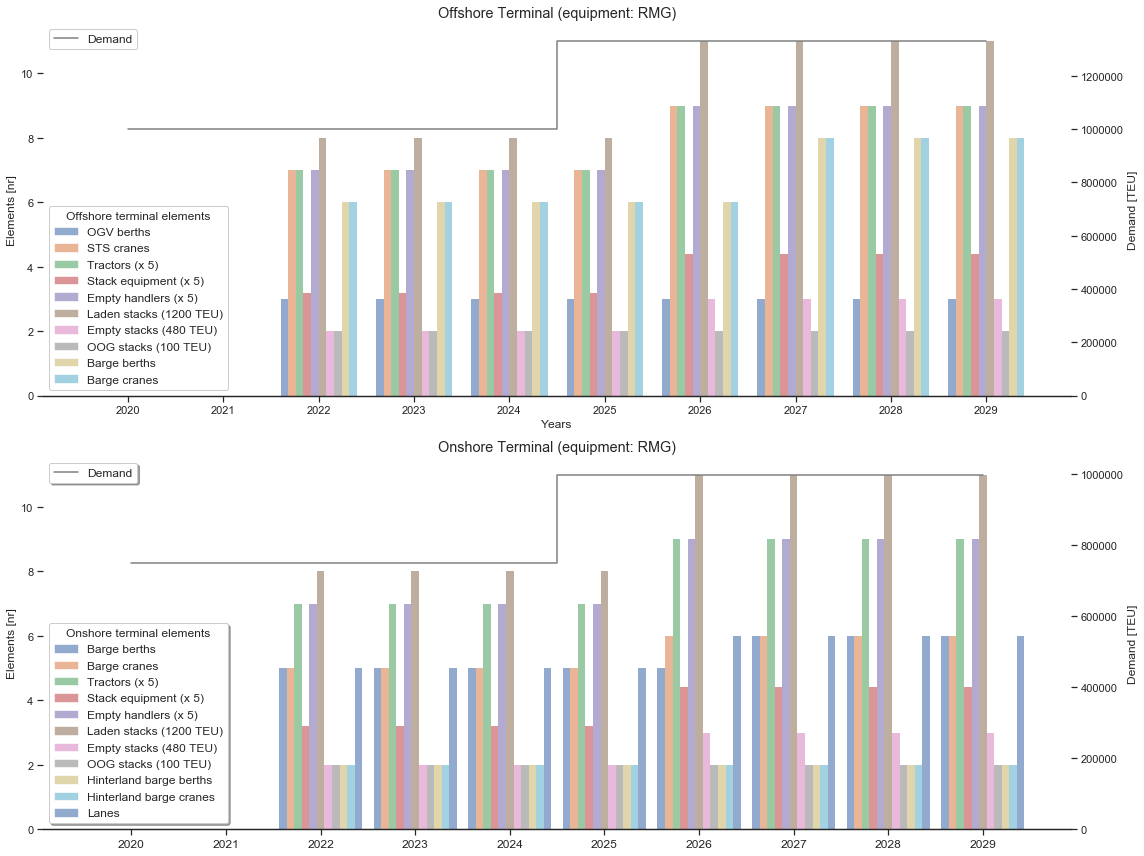

In [13]:
OffshoreBarge.terminal_elements_plot()
sns.despine(left=True)

# save fig
if lifecycle == 10:
    if scenario_demand == demand_0:
        plt.savefig("SaveFigures/Alt_2/terminal_elements_1.png", bbox_inches = 'tight')
    if scenario_demand == demand_2:
        plt.savefig("SaveFigures/Alt_2/terminal_elements_2.png", bbox_inches = 'tight')

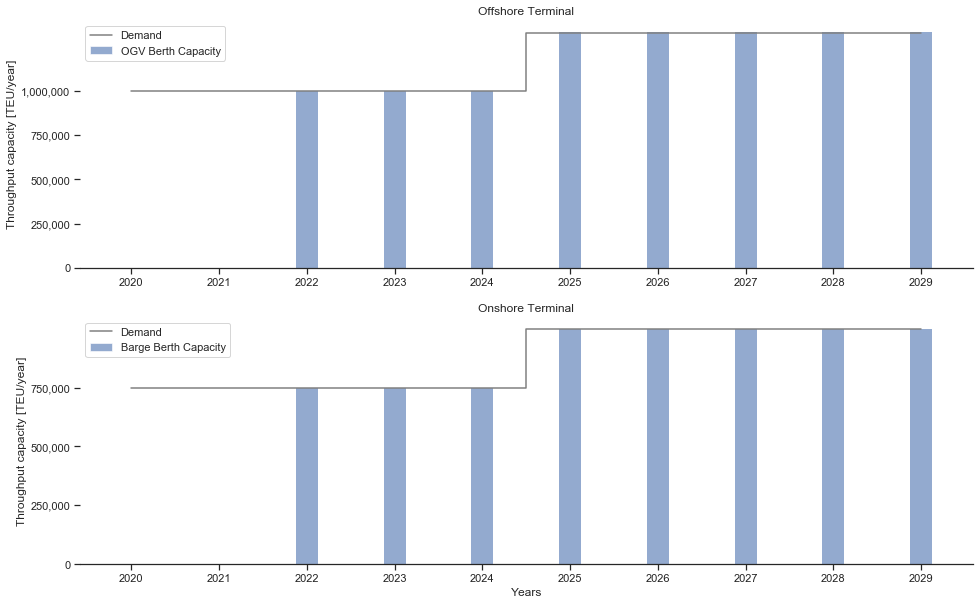

In [14]:
OffshoreBarge.terminal_capacity_plot()
sns.despine(left=True)

# save fig
if lifecycle == 10:
    if scenario_demand == demand_0:
        plt.savefig("SaveFigures/Alt_2/terminal_capacity_1.png")
    if scenario_demand == demand_2:
        plt.savefig("SaveFigures/Alt_2/terminal_capacity_2.png")

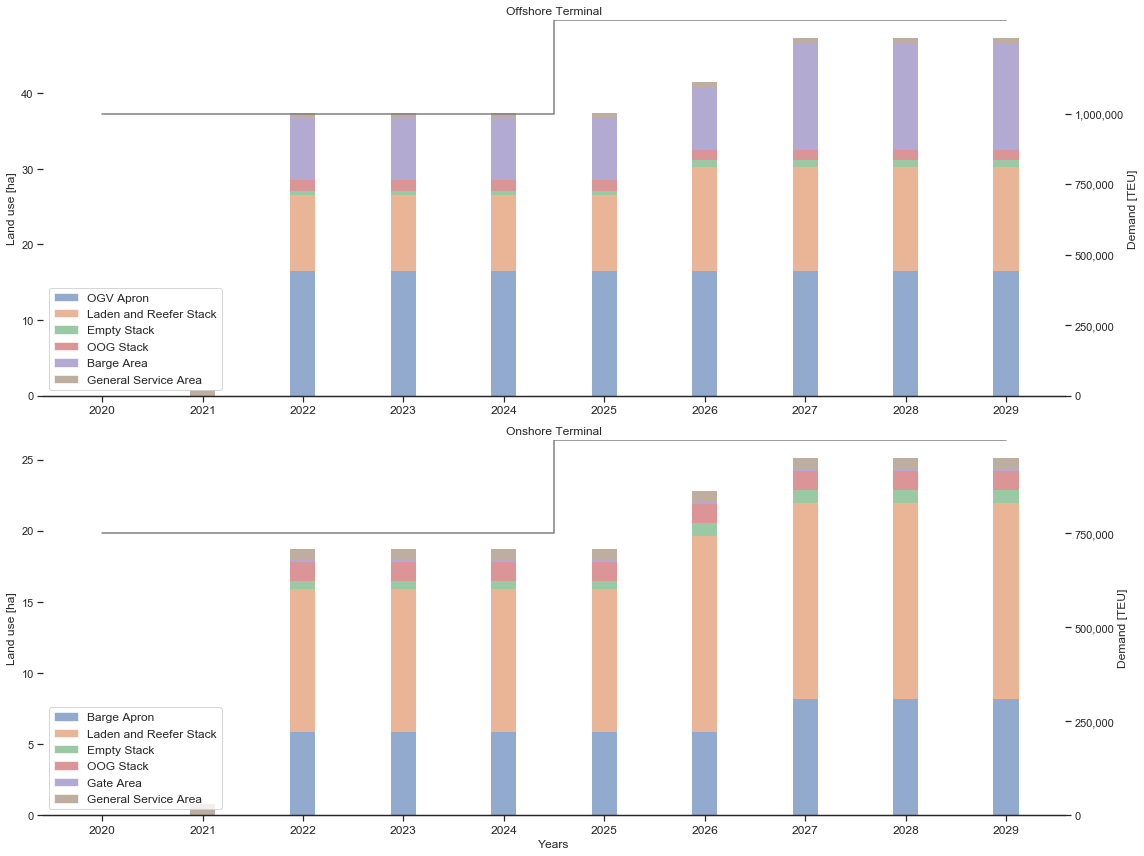

In [15]:
OffshoreBarge.terminal_land_use_plot(False)
sns.despine(left=True)

# save fig
if lifecycle == 10:
    if scenario_demand == demand_0:
        plt.savefig("SaveFigures/Alt_2/storage_area_1.png")
    if scenario_demand == demand_2:
        plt.savefig("SaveFigures/Alt_2/storage_area_2.png")

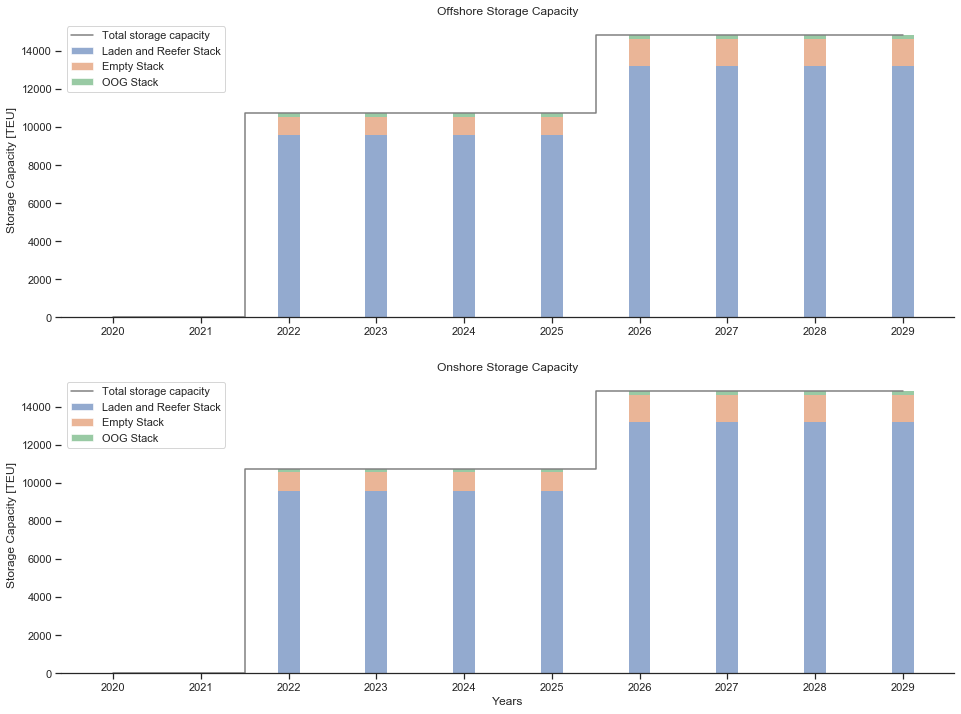

In [16]:
OffshoreBarge.storage_capacity_plot(False)
sns.despine(left=True)

# save fig
if lifecycle == 10:
    if scenario_demand == demand_0:
        plt.savefig("SaveFigures/Alt_2/storage_capacity_1.png")
    if scenario_demand == demand_2:
        plt.savefig("SaveFigures/Alt_2/storage_capacity_2.png")

In [17]:
hide_columns_list = []
# hide_columns_list = ['Offshore Maintenance', 'Offshore Insurance', 'Offshore Energy', 
#                      'Offshore Labour', 'Offshore Fuel', 'Offshore Demurrage',
#                      'Onshore Maintenance', 'Onshore Insurance', 'Onshore Energy', 
#                      'Onshore Labour', 'Onshore Fuel', 'Onshore Demurrage', 'revenues']
cash_flows_WACC_real_df.style.hide_columns(hide_columns_list).hide_index()

Year,Reclamation,Coastal Protection,Coastal Structures Maintenance,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Energy,Offshore Labour,Offshore Fuel,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Energy,Onshore Labour,Onshore Fuel,Ocean Transport,Demurrage,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour,Capital Dredging,Maintenance Dredging
2020,1.61265e+08,1.08976e+08,0,2.93953e+08,0,0,0,0,0,7.69487e+07,0,0,0,0,0,0,0,0,0,0,0,9.18811e+07,0
2021,2.00688e+07,1.05998e+06,1.68435e+06,3.5497e+08,0,0,1.35828e+06,0,0,1.5705e+08,0,0,1.39615e+06,0,0,0,0,3.43269e+08,0,0,0,8.66482e+07,0
2022,0,0,1.77078e+06,0,1.77868e+07,4.44871e+06,7.98096e+06,1.30622e+07,2.06148e+06,0,2.85239e+07,1.42171e+06,1.01449e+07,1.39515e+07,106748,5.33603e+07,0,0,3.66529e+06,1.6186e+07,2.80142e+06,0,5.88336e+06
2023,0,0,1.66993e+06,0,1.67738e+07,4.19535e+06,7.52643e+06,1.23182e+07,1.94407e+06,0,2.68994e+07,1.34074e+06,9.56709e+06,1.31569e+07,100668,5.03213e+07,0,0,3.45654e+06,1.52641e+07,2.64187e+06,0,5.54829e+06
2024,0,0,1.57482e+06,0,1.58185e+07,3.95641e+06,7.09778e+06,1.16167e+07,1.83335e+06,0,2.53674e+07,1.26438e+06,9.02222e+06,1.24076e+07,94935,4.74554e+07,0,0,3.25968e+06,1.43948e+07,2.49141e+06,0,5.2323e+06
2025,4.22472e+07,1.01565e+07,1.48513e+06,8.27352e+07,1.49175e+07,3.73108e+06,8.54789e+06,1.09551e+07,2.29949e+06,4.09624e+07,2.39227e+07,1.19237e+06,1.09517e+07,1.1701e+07,119072,4.47526e+07,0,2.38681e+08,3.07403e+06,1.3575e+07,2.34951e+06,0,4.93431e+06
2026,0,0,1.72194e+06,3.94056e+07,1.93434e+07,3.66166e+06,8.06107e+06,1.30568e+07,2.16853e+06,1.14744e+07,3.05688e+07,1.17215e+06,1.0328e+07,1.398e+07,112290,4.22039e+07,0,0,3.9343e+06,2.40562e+07,3.00703e+06,0,4.65328e+06
2027,0,0,1.62387e+06,0,1.82418e+07,4.15229e+06,7.60197e+06,1.2562e+07,2.04502e+06,0,2.90725e+07,1.35003e+06,9.7398e+06,1.31838e+07,105895,5.29343e+07,0,0,3.71023e+06,2.26861e+07,2.83577e+06,0,4.38827e+06
2028,0,0,1.53139e+06,0,1.72029e+07,3.9158e+06,7.16901e+06,1.18465e+07,1.92855e+06,0,2.74167e+07,1.27314e+06,9.18509e+06,1.2433e+07,99864,4.99196e+07,0,0,3.49892e+06,2.13941e+07,2.67426e+06,0,4.13834e+06
2029,0,0,1.44417e+06,0,1.62231e+07,3.69279e+06,6.76072e+06,1.11718e+07,1.81872e+06,0,2.58553e+07,1.20064e+06,8.66198e+06,1.17249e+07,94176.5,4.70765e+07,0,0,3.29965e+06,2.01757e+07,2.52196e+06,0,3.90265e+06


In [18]:
print('\033[1m    Cost Estimate\033[0m')
print(' ** PV of the costs: ${}'.format(f'{round(PV,-6):,}'))

    Cost Estimate
 ** PV of the costs: $3,553,000,000.0


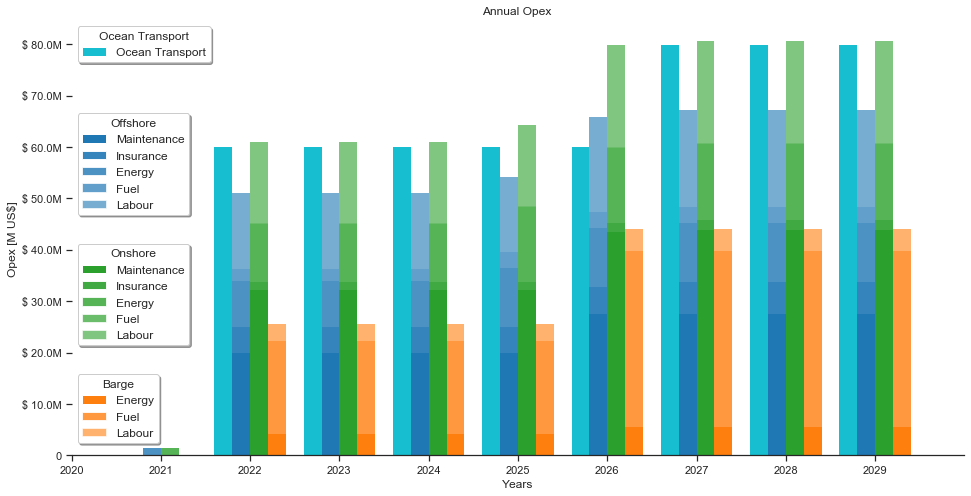

In [19]:
OffshoreBarge.terminal_opex_plot(cash_flows_df, False)
sns.despine(left=True)

# save fig
if lifecycle == 10:
    if scenario_demand == demand_0:
        plt.savefig("SaveFigures/Alt_2/opex_1.png")
    if scenario_demand == demand_2:
        plt.savefig("SaveFigures/Alt_2/opex_2.png")

 Cost Estimation Plot


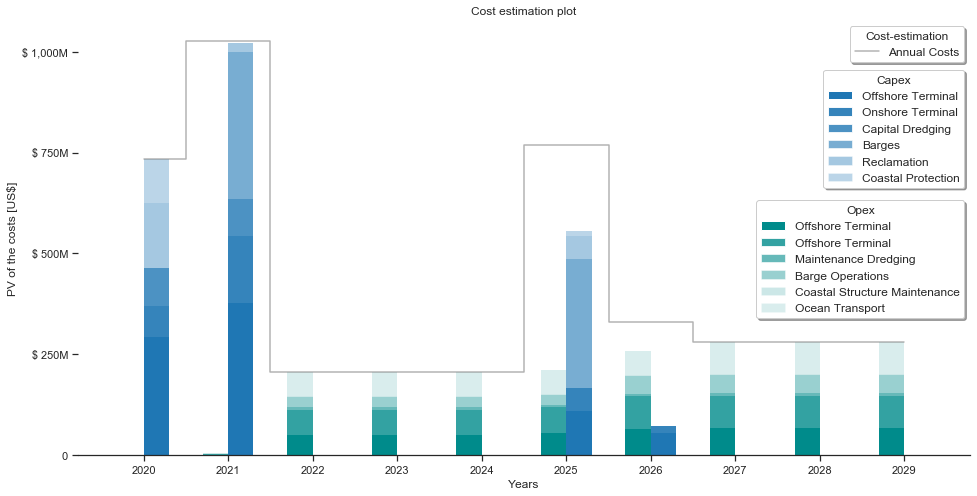

In [20]:
print('\033[1m Cost Estimation Plot\033[0m')
OffshoreBarge.cashflow_plot(cash_flows_df)
sns.despine(left=True)

# save fig
if lifecycle == 10:
    if scenario_demand == demand_0:
        plt.savefig("SaveFigures/Alt_2/cash_flow_plot_1.png", bbox_inches = 'tight')
    if scenario_demand == demand_2:
        plt.savefig("SaveFigures/Alt_2/cash_flow_plot_2.png", bbox_inches = 'tight')

 Cost Estimation Plot - Weighted average cost of capital 


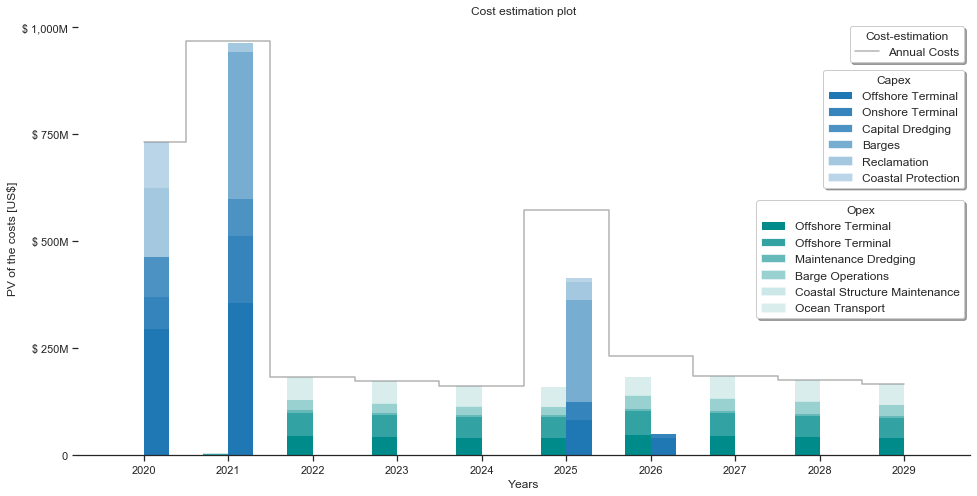

In [21]:
print('\033[1m Cost Estimation Plot - Weighted average cost of capital \033[0m')
OffshoreBarge.cashflow_plot(cash_flows_WACC_real_df)
sns.despine(left=True)

# save fig
if lifecycle == 10:
    if scenario_demand == demand_0:
        plt.savefig("SaveFigures/Alt_2/cash_flow_plot_WACC_1.png", bbox_inches = 'tight')
    if scenario_demand == demand_2:
        plt.savefig("SaveFigures/Alt_2/cash_flow_plot_WACC_2.png", bbox_inches = 'tight')

In [22]:
# OffshoreBarge.element_cashflow_plot()

In [23]:
print("Offshore terminal capacity for initial demand:")
total_offshore_ground_slots, total_offshore_stack_capacity, total_offshore_stack_online = OffshoreBarge.total_stack_capacity(2023)

total_offshore_ground_slots = round(total_offshore_ground_slots,-1)
total_offshore_stack_capacity = round(total_offshore_stack_capacity,-1)
      
%store total_offshore_ground_slots
%store total_offshore_stack_capacity

Offshore terminal capacity for initial demand:
     Total Ground Slots required   (@ start of year):  1,990
     Total Stack capacity required (@ start of year):  10,200 TEU
     Total Stack capacity online   (@ start of year):  10,800 TEU

Stored 'total_offshore_ground_slots' (float)
Stored 'total_offshore_stack_capacity' (int)
